In [ ]:
# Retrieve variables from train_test_split notebook
%store -r X_train_scaled
%store -r X_test_scaled
%store -r Y_train
%store -r Y_test
%store -r X_train
%store -r df
%store -r X_val_scaled
%store -r Y_val
%store -r X_train_val_scaled
%store -r Y_train_val

In [ ]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
import pandas as pd
import numpy as np
from sksurv.linear_model import CoxnetSurvivalAnalysis
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import polars as pl

# Regression

## Cox proportional hazard model

In [ ]:
survival = CoxPHSurvivalAnalysis() # creating variable with the cox proportional hazard model 
survival.fit(X_train_scaled, Y_train.to_numpy(structured=True)) # fit the coxph on the x scaled training set and on the y training set
survival.score(X_val_scaled, Y_val.to_numpy(structured=True)) # calculate concordance index

0.7862181516152366

In [ ]:
# creating a table with the coefficient of the cox proportional hazard model
weights_df = pd.DataFrame(
    survival.coef_,
    index=X_train.columns,
    columns=["weights"]
)
weights_df

,weights
Current ratio 2014,-0.496742
Interest/Operating profit % 2014,0.012634
Working capital to total assets 2014,0.331096
Return on asset (ROA) % 2014,0.093658
Sales to total assets 2014,0.207328
Stocks/Turnover (days) 2014,-0.105697
Leverage 2014,0.008713
Return on sales (ROS) % 2014,-0.005080
Cash to total assets 2014,0.084532
Current liabilities/Tot ass. % 2014,0.279187


## Elastic net

In [ ]:
estimator_elasticnet = CoxnetSurvivalAnalysis(l1_ratio=0.5,  n_alphas=100) # coxnet survival model with l1 ratio 0.5  
estimator_elasticnet.fit(X_train_scaled, Y_train.to_numpy(structured=True)) # fit the coxnet on the x scaled training set and y training set

# dataframe with the coefficient in order to display the shrinked coefficients
pd.DataFrame(
    estimator_elasticnet.coef_,
    index = X_train.columns,
    columns = np.round(estimator_elasticnet.alphas_,10)
)
estimator_elasticnet.coef_.shape # check the shape of the estimator of the coxnet

(51, 65)

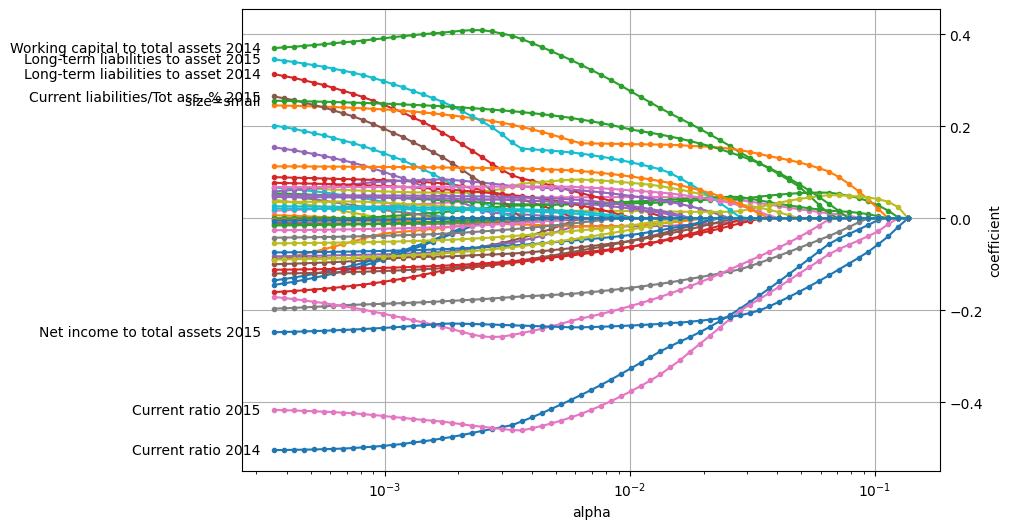

In [ ]:
# plot coxnet for the feature importance
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    # plot setting
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

coefficients_lasso = pd.DataFrame(estimator_elasticnet.coef_, index=X_train.columns, columns=np.round(estimator_elasticnet.alphas_, 10)) # creating dataframe to plot the coefficients

plot_coefficients(coefficients_lasso, n_highlight=8)

## Choosing alpha and l1 ratio

In [ ]:
coxnet_pipe = make_pipeline(
    CoxnetSurvivalAnalysis(l1_ratio=0.5)
) # creating variable of coxnet to use in the cross validation with l1 ratio 0.5
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(X_train_scaled, Y_train.to_numpy(structured=True)) # fit the coxnet to x train scaled and y train 

Pipeline(steps=[('coxnetsurvivalanalysis', CoxnetSurvivalAnalysis())])

In [ ]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_ # taking alpha from the coxnet variable to train in the cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=328) 
param_grid = {
    "alphas": [[v] for v in estimated_alphas],
    "l1_ratio" : [0.1,0.5,0.9],
    "alpha_min_ratio": [0.001, 0.00004]
} # setting parameters to train in the cross validation
# using grid search cross validation to find out the best parameter for the coxnet score
gcv = GridSearchCV(
    CoxnetSurvivalAnalysis(),
    param_grid=param_grid,
    cv=cv,
    error_score=0.5,
    n_jobs=-1).fit(X_train_val_scaled, Y_train_val.to_numpy(structured=True))

cv_results = pd.DataFrame(gcv.cv_results_)
estimated_alphas # check if it takes all the number of alphas

array([0.13646943, 0.12434586, 0.11329932, 0.10323412, 0.09406309,
       0.08570678, 0.07809283, 0.07115528, 0.06483404, 0.05907436,
       0.05382636, 0.04904457, 0.04468759, 0.04071766, 0.03710042,
       0.03380452, 0.03080142, 0.02806511, 0.02557188, 0.02330014,
       0.02123022, 0.01934419, 0.01762571, 0.01605989, 0.01463317,
       0.0133332 , 0.01214871, 0.01106946, 0.01008608, 0.00919006,
       0.00837364, 0.00762975, 0.00695194, 0.00633435, 0.00577162,
       0.00525889, 0.0047917 , 0.00436602, 0.00397816, 0.00362475,
       0.00330274, 0.00300933, 0.00274199, 0.0024984 , 0.00227645,
       0.00207421, 0.00188995, 0.00172205, 0.00156907, 0.00142968,
       0.00130267, 0.00118694, 0.0010815 , 0.00098542, 0.00089788,
       0.00081811, 0.00074543, 0.00067921, 0.00061887, 0.00056389,
       0.0005138 , 0.00046815, 0.00042656, 0.00038867, 0.00035414])

In [ ]:
gcv.best_params_ # best parameters of the grid search cross validation

{'alpha_min_ratio': 0.001, 'alphas': [0.0036247479280241083], 'l1_ratio': 0.1}

In [ ]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha_min_ratio,param_alphas,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.069040,0.024170,0.035159,0.022878,0.001,[0.13646943264814773],0.1,"{'alpha_min_ratio': 0.001, 'alphas': [0.136469...",0.757273,0.730366,0.744630,0.736980,0.753368,0.744523,0.009981,317
1,0.033512,0.028871,0.051167,0.032069,0.001,[0.13646943264814773],0.5,"{'alpha_min_ratio': 0.001, 'alphas': [0.136469...",0.717876,0.697695,0.712066,0.688752,0.725920,0.708462,0.013497,375
2,0.022353,0.027411,0.045255,0.030625,0.001,[0.13646943264814773],0.9,"{'alpha_min_ratio': 0.001, 'alphas': [0.136469...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,379
3,0.043998,0.028539,0.072682,0.025804,0.001,[0.12434586437720342],0.1,"{'alpha_min_ratio': 0.001, 'alphas': [0.124345...",0.758524,0.731141,0.744864,0.737498,0.754723,0.745350,0.010249,311
4,0.011155,0.002036,0.086506,0.003046,0.001,[0.12434586437720342],0.5,"{'alpha_min_ratio': 0.001, 'alphas': [0.124345...",0.719651,0.701184,0.714976,0.695136,0.718097,0.709809,0.009818,369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,0.198966,0.009854,0.024515,0.008656,0.00004,[0.0003886698391270087],0.5,"{'alpha_min_ratio': 4e-05, 'alphas': [0.000388...",0.773767,0.746619,0.754860,0.753581,0.765159,0.758797,0.009546,125
386,0.212584,0.012144,0.021905,0.006746,0.00004,[0.0003886698391270087],0.9,"{'alpha_min_ratio': 4e-05, 'alphas': [0.000388...",0.774010,0.746833,0.754883,0.753663,0.764972,0.758872,0.009532,105
387,0.229386,0.012324,0.065352,0.005718,0.00004,[0.0003541414818379291],0.1,"{'alpha_min_ratio': 4e-05, 'alphas': [0.000354...",0.773522,0.746340,0.754585,0.753466,0.765056,0.758594,0.009562,153
388,0.178700,0.030306,0.067832,0.034062,0.00004,[0.0003541414818379291],0.5,"{'alpha_min_ratio': 4e-05, 'alphas': [0.000354...",0.773739,0.746614,0.754808,0.753527,0.765145,0.758767,0.009546,127


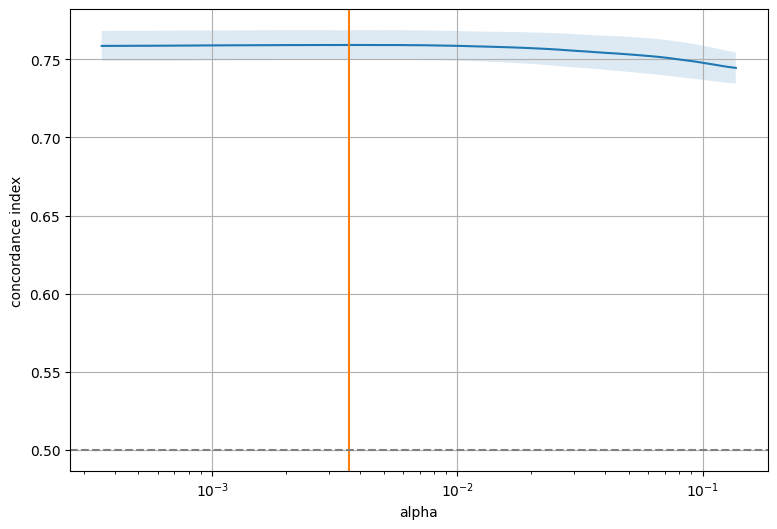

In [ ]:
cv_results = cv_results.query("param_alpha_min_ratio== 0.001 & param_l1_ratio== 0.1") # filter for l1 ratio and alpha_min_ratio to not have all the iteration
alphas = cv_results.param_alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score 
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

Number of non-zero coefficients: 47


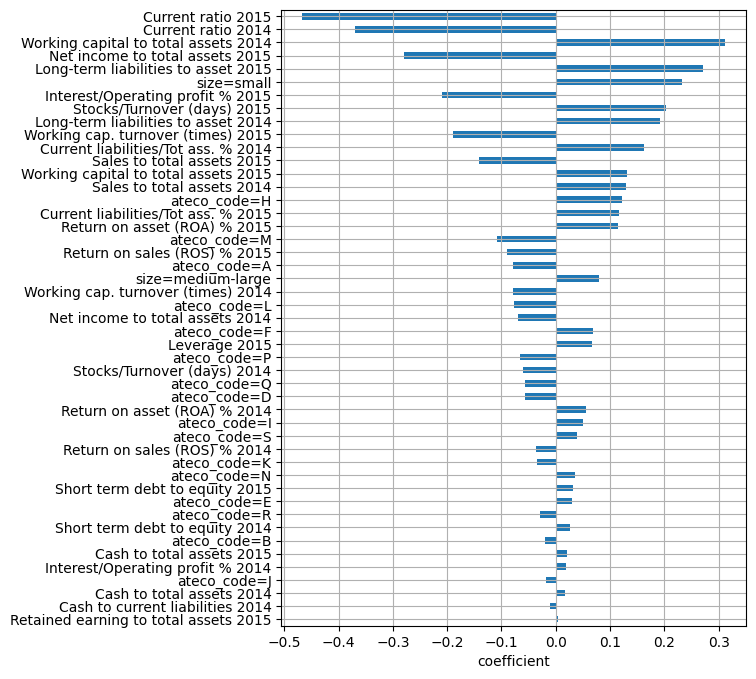

In [ ]:
best_model = gcv.best_estimator_ # selecting the best estimators from the cross validation model
best_coefs = pd.DataFrame(best_model.coef_, index=X_train.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0) # count of the coefficients that were not shrinked
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0") # selecting the non zero coefficients
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

# plot the non zero coefficients 
_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

Number of non-zero coefficients: 47


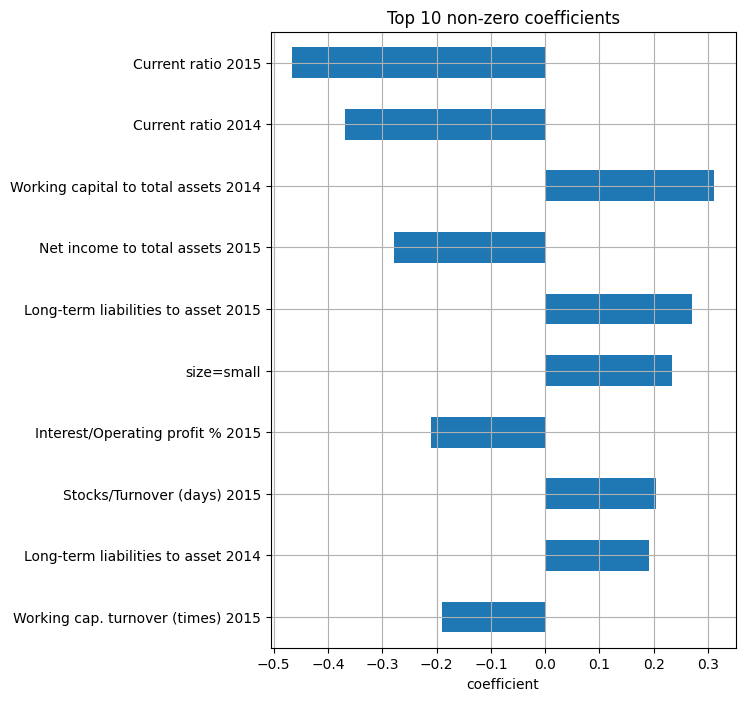

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming you already have the best_model and X_train
best_model = gcv.best_estimator_  # Replace gcv with your cross-validation object
best_coefs = pd.DataFrame(best_model.coef_, index=X_train.columns, columns=["coefficient"])



non_zero = np.sum(best_coefs.iloc[:, 0] != 0) 
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

# Plot the last 10 non-zero coefficients
_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order][-10:].plot.barh(ax=ax, legend=False) # select the first 10 coefficients for visualization purposes
ax.set_xlabel("coefficient")
ax.set_title("Top 10 non-zero coefficients")
ax.grid(True)

plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cda3dc7f-2383-4ca3-97fb-1b86671fd3dc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>